# Simple Gaussian Processes and Bayesian Optimization in 1D


This tutorial intorduces the key libraries for Gaussian Processes and Bayesian Optimization, [GPyTorch](https://gpytorch.ai/) and [BoTorch](https://botorch.org/docs/getting_started/) with GPU acceleration. It contains two simple examples of:
1.  **Gaussian Process (GP) regression** in 1D.
2. **Bayesian Optimization (BO)** in 1D using the GP as surrogate model.

We will later build on top of this code.

Recommended resorces:
- GPs: https://distill.pub/2019/visual-exploration-gaussian-processes/

In [1]:
!pip install botorch gpytorch numpy==1.26

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import torch
import gpytorch


from botorch.models.gp_regression import SingleTaskGP
from gpytorch.kernels import RBFKernel, ScaleKernel, Kernel
from botorch.models.transforms.outcome import Standardize
from botorch.models.transforms.input import Normalize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_mll
from botorch.acquisition import UpperConfidenceBound


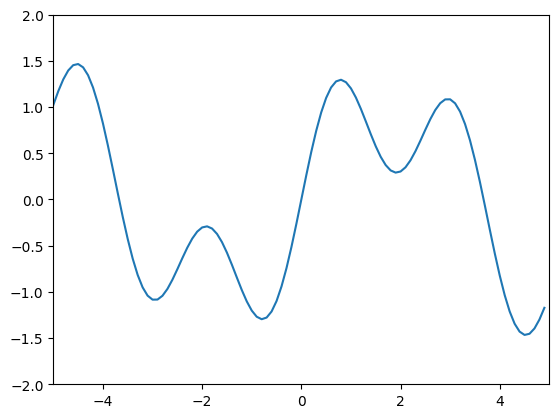

In [3]:
# Define a ground truth function to learn
f = lambda x: torch.sin(0.9*x) + 0.7*torch.sin(2.5*x)

x = torch.arange(-5, 5, 0.1)
plt.plot(x, f(x))
plt.axis([-5, 5, -2, 2])
plt.show()

In [4]:
class GP(SingleTaskGP):
    def __init__(
        self,
        train_x: torch.Tensor,
        train_y: torch.Tensor,
        kernel: Kernel = None,
        standardize: bool = True,
        normalize: bool = False,
    ):
        self._set_dimensions(train_X=train_x, train_Y=train_y)

        super().__init__(
            train_x,
            train_y,
            covar_module=ScaleKernel(base_kernel=kernel),
            outcome_transform=Standardize(train_y.shape[-1]) if standardize else None,
            input_transform=Normalize(train_x.shape[-1]) if normalize else None,
        )

        self.kernel = kernel
        self.standardize = standardize
        self.normalize = normalize

    def reinit(self, train_x, train_y):
        return GP(
            train_x,
            train_y,
            self.kernel,
            self.standardize,
            self.normalize,
        )

In [5]:
def fit_gp(train_x, train_y, kernel=None, optimize=True):
    """Fit GP using your GP class. If optimize=False, returns untrained GP."""
    gp = GP(train_x, train_y, kernel=kernel or RBFKernel())
    gp.double()

    if optimize:
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        fit_gpytorch_mll(mll)
        print("Lengthscale:", gp.covar_module.base_kernel.lengthscale.item())
        print("Outputscale:", gp.covar_module.outputscale.item())
        print("Noise:", gp.likelihood.noise.item())

    else:
        gp.eval()
        gp.likelihood.eval()
    return gp

def predict_gp(gp, test_x):
    """Return posterior mean and confidence region."""
    posterior = gp.posterior(test_x)
    mean = posterior.mean.detach()
    lower, upper = posterior.mvn.confidence_region()
    return mean, lower, upper

def plot_gp(train_x, train_y, test_x, f, mean, lower, upper, title):
    plt.figure(figsize=(10,6))
    plt.plot(train_x.detach().numpy(), train_y.detach().numpy(), "r*", label="Training data")
    plt.plot(test_x.detach().numpy(), mean.detach().numpy(), "b", label="Posterior mean")
    plt.fill_between(test_x.detach().numpy().flatten(),
                     lower.detach().numpy(), upper.detach().numpy(),
                     alpha=0.3, label="Confidence region")
    plt.plot(test_x.detach().numpy(), f(test_x).detach().numpy(), "k--", label="True function")
    plt.legend()
    plt.title(title)
    plt.show()

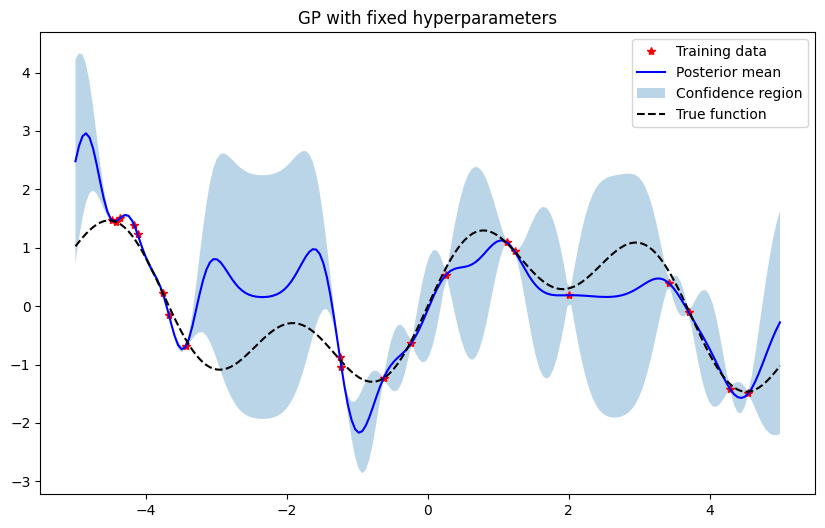

In [6]:
# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)      # PyTorch
np.random.seed(seed)         # NumPy

# Generating data
N = 20
n = 200
noise_std = 0.1

train_x = -5 + 10 * torch.rand(N, 1, dtype=torch.double)
# only the noisy samples of the ground truth funciton are available to us
train_y = f(train_x) + noise_std*torch.randn_like(train_x)
test_x = torch.linspace(-5, 5, n, dtype=torch.double).unsqueeze(-1)

# ---- GP with fixed hyperparameters ----
gp_fixed = fit_gp(train_x, train_y, kernel=RBFKernel(), optimize=False)

#########
# TODO:
# you can try out to chage the hyperparameters of GP and see the predictions
#########

gp_fixed.covar_module.base_kernel.lengthscale = 0.3
gp_fixed.covar_module.outputscale = 1.0
gp_fixed.likelihood.noise = 5e-5

mean_fixed, lower_fixed, upper_fixed = predict_gp(gp_fixed, test_x)
plot_gp(train_x, train_y, test_x, f, mean_fixed, lower_fixed, upper_fixed,
        "GP with fixed hyperparameters")


No let's optimize hyperparamters of GP via optimizing marginal log-likelihood

Lengthscale: 0.6540305148100523
Outputscale: 0.8069203286790944
Noise: 0.004088640880250116


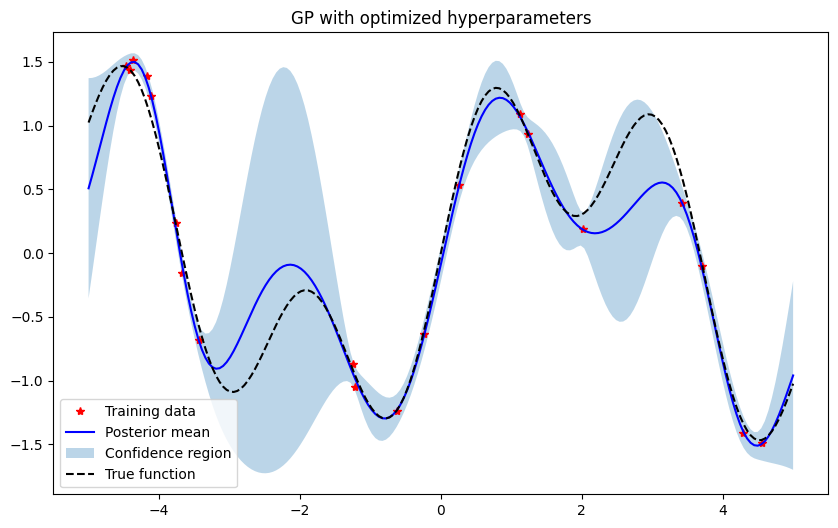

In [7]:
# ---- GP with optimized hyperparameters ----
gp_opt = fit_gp(train_x, train_y, kernel=RBFKernel(), optimize=True)
mean_opt, lower_opt, upper_opt = predict_gp(gp_opt, test_x)
plot_gp(train_x, train_y, test_x, f, mean_opt, lower_opt, upper_opt,
        "GP with optimized hyperparameters")

## Bayesian optimization
With Bayesian Optimization, we want to **optimize** the unknown objective $f(x)$ with as few steps as possible. A **surrogate model** (often a Gaussian Process) is used to model the unknown function. The GP posterior gives us a predictive mean $\mu(x)$ and uncertainty $\sigma(x)$.

The acquisition function decides where to evaluate next by balancing exploration (uncertain areas) and exploitation (areas with high mean prediction).

The critical step is to estimate for what input to query the unknown function next $x_{next}$, such that the min/max is found within the fewest steps:
$$x_{next} = \underset{x}{\arg\max}\; \alpha(x| \mu(x) \, ,\sigma(x)) $$, where $\alpha(\cdot)$ is the acquisition function.


In the following example, the goal is to find a maximum (within a specified number of iterations) of the function that we previously approximated. We have picked the Upper Confidence Bound (UCB) for aquisition function, but there are other options. UCB is given by the follwing equation:
$$
UCB(x) = \mu(x) + \sqrt\beta \sigma(x)
$$

In [8]:
def plot_bo_state(train_x, train_y, test_x, f, mean, lower, upper, acq_values, next_x, iteration):
    fig, ax1 = plt.subplots(figsize=(10,6))
    ax1.set_title(f"Iteration {iteration}: GP Posterior & Acquisition")
    ax1.plot(train_x.detach().numpy(), train_y.detach().numpy(), "r*", label="Train data")
    ax1.plot(test_x.detach().numpy(), mean.detach().numpy(), "b", label="Posterior mean")
    ax1.fill_between(test_x.detach().numpy().flatten(),
                     lower.detach().numpy(), upper.detach().numpy(),
                     alpha=0.3, label="Confidence region")
    ax1.plot(test_x.detach().numpy(), f(test_x).detach().numpy(), "k--", label="True function")
    ax1.axvline(next_x.item(), color="g", linestyle="--", label="Next candidate")
    ax1.legend(loc="upper left")
    ax1.set_ylabel("Function value")

    ax2 = ax1.twinx()
    ax2.plot(test_x.numpy(), acq_values, "purple", label="Acquisition (UCB)")
    ax2.legend(loc="lower left")
    ax2.set_ylabel("Acquisition value")
    plt.show()

# ---- Bayesian Optimization ----
def run_bo(train_x, train_y, heldout_x, heldout_y, num_iterations=10, beta=0.25, plot_freq = 2):
    gp = GP(train_x, train_y, kernel=RBFKernel())
    gp.double()
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

    best_value = train_y.max().item()
    best_values = [best_value]

    # Test grid for plotting posterior/acquisition
    test_x = torch.linspace(-5, 5, 400, dtype=torch.double).unsqueeze(-1)

    for i in range(num_iterations):
        with gpytorch.settings.fast_computations(covar_root_decomposition=False):
            fit_gpytorch_mll(mll, max_retries=50)

        # Posterior
        posterior = gp.posterior(test_x)
        mean = posterior.mean.detach()
        lower, upper = posterior.mvn.confidence_region()

        # Acquisition on heldout pool
        acq_func = UpperConfidenceBound(gp, beta=beta)
        acq_values = acq_func(test_x.unsqueeze(-2)).detach().numpy()
        best_candidate_idx = acq_func(heldout_x.unsqueeze(-2)).view(-1).argmax()
        best_candidate = heldout_x[best_candidate_idx]

        # Plot current state
        if (i + 1) % plot_freq == 0:
          plot_bo_state(train_x, train_y, test_x, f, mean, lower, upper,
                        acq_values, best_candidate, i+1)

        # Update datasets
        train_x = torch.vstack([train_x, best_candidate])
        train_y = torch.vstack([train_y, heldout_y[best_candidate_idx]])
        heldout_x = torch.cat([heldout_x[:best_candidate_idx], heldout_x[best_candidate_idx+1:]])
        heldout_y = torch.cat([heldout_y[:best_candidate_idx], heldout_y[best_candidate_idx+1:]])

        # Reinitialize GP with updated data
        gp = gp.reinit(train_x, train_y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

        new_best_value = train_y.max().item()
        if new_best_value > best_value:
            best_value = new_best_value
        best_values.append(best_value)

    return np.array(best_values)

In [9]:
# ---- Generate dataset (pool of points to choose from) ----
N_init = 5     # initial training points
N_pool = 200   # candidate pool

# Candidate pool of size N_pool
all_x = -5 + 10 * torch.rand(N_pool, 1, dtype=torch.double)
all_y = f(all_x) + noise_std * torch.randn_like(all_x)

# Split into train / heldout
perm = torch.randperm(N_pool)
train_idx, heldout_idx = perm[:N_init], perm[N_init:]
train_x, train_y = all_x[train_idx], all_y[train_idx]
heldout_x, heldout_y = all_x[heldout_idx], all_y[heldout_idx]

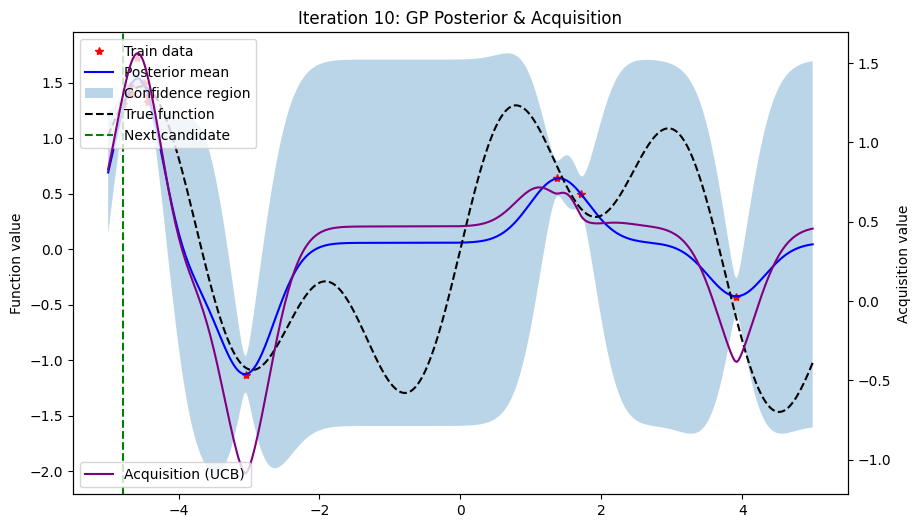

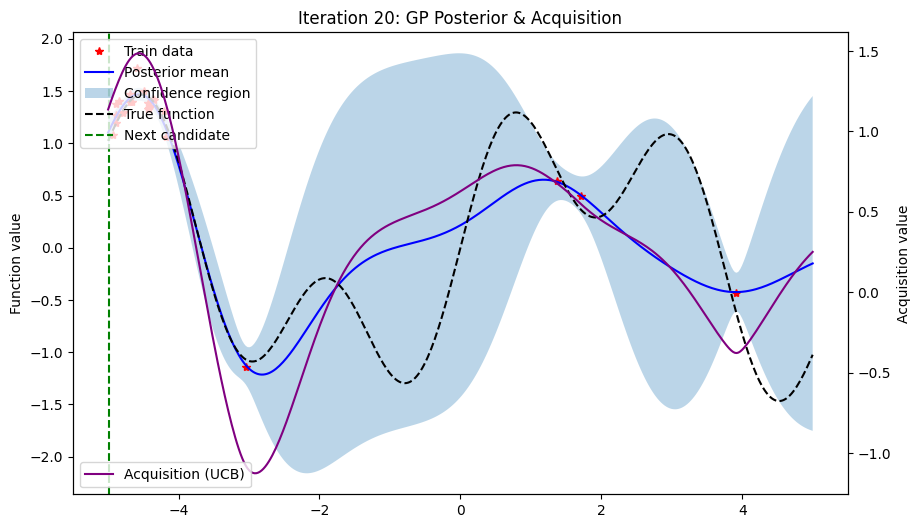

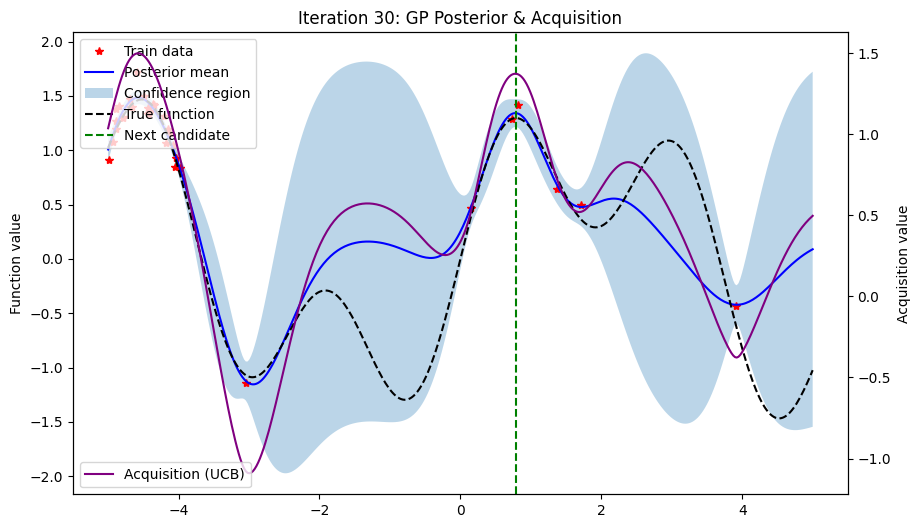

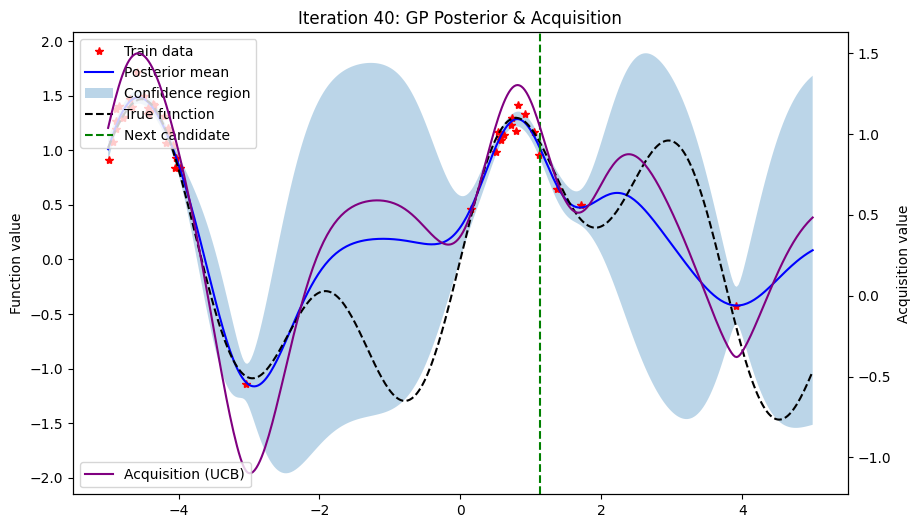

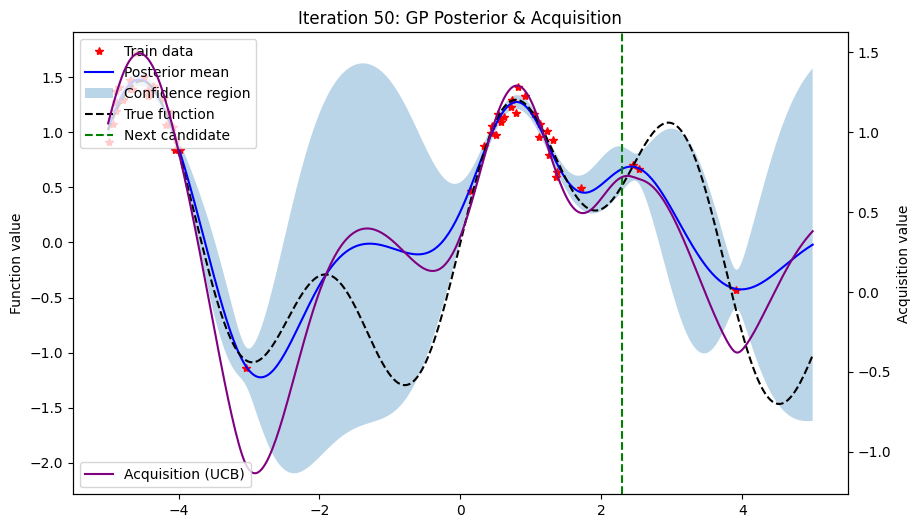

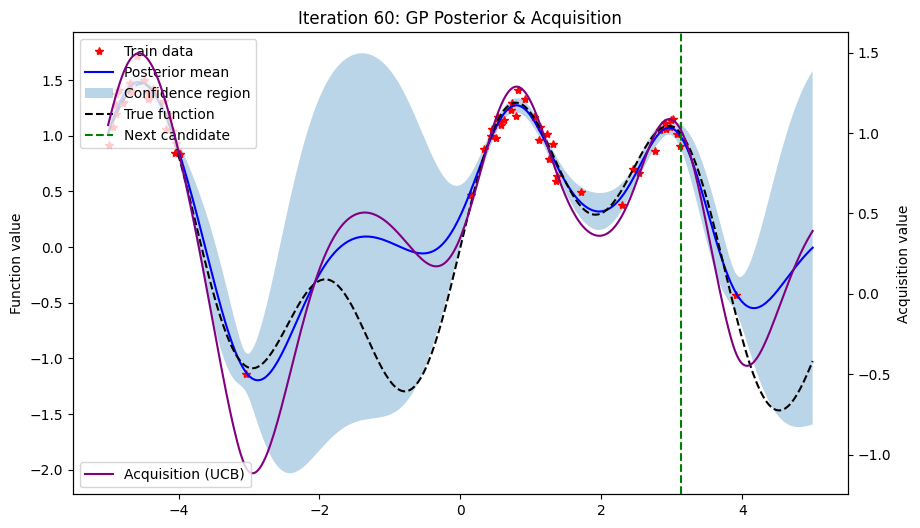

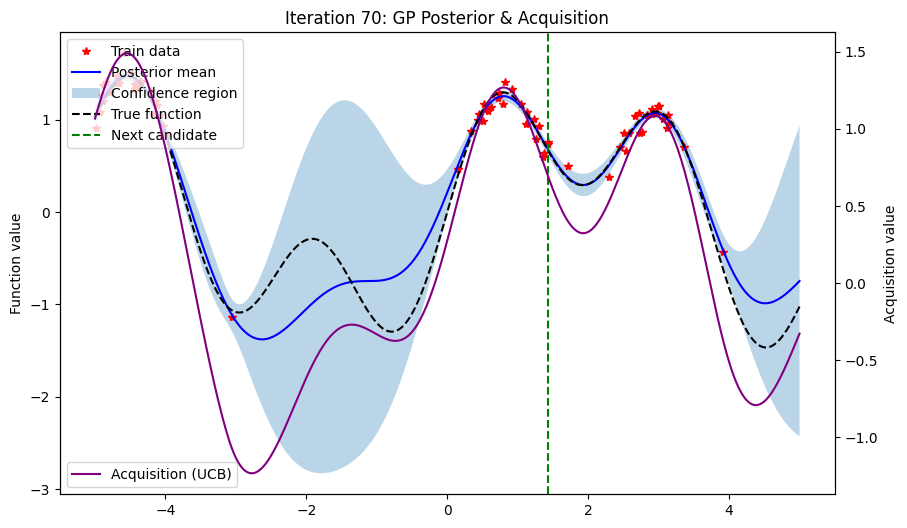

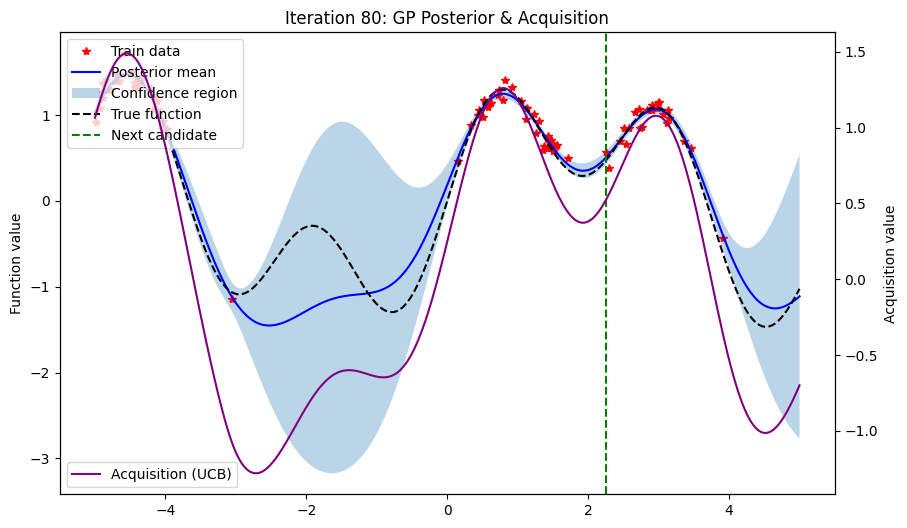

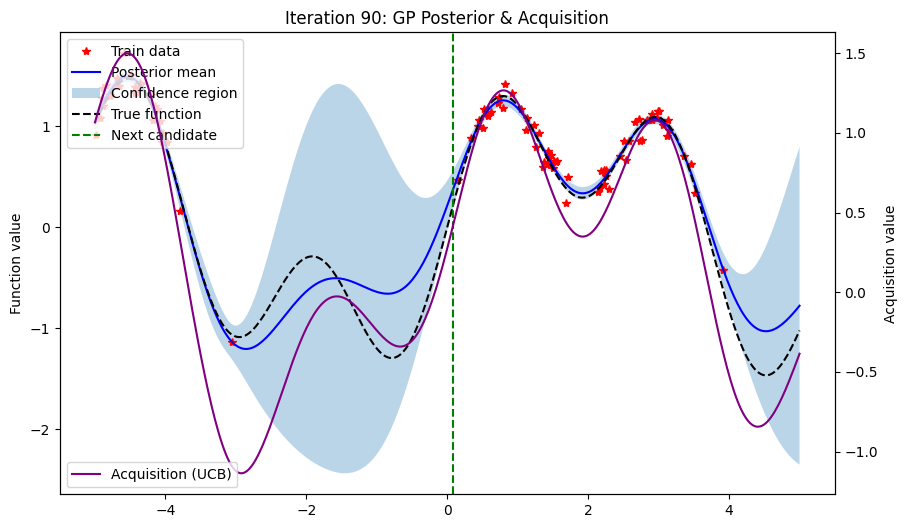

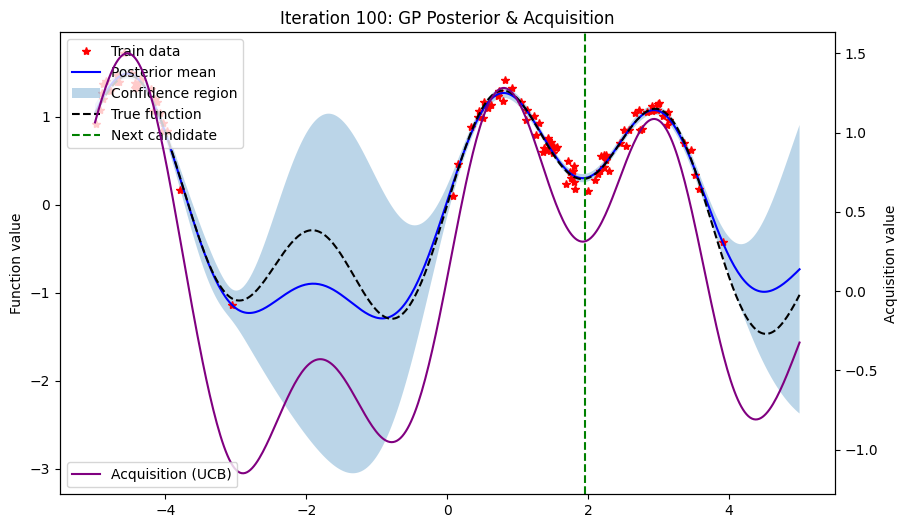

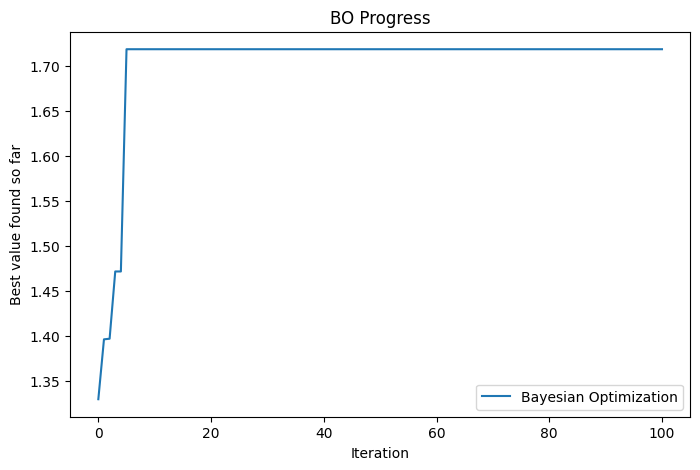

In [10]:
bo_curve = run_bo(train_x.clone(), train_y.clone(),
                  heldout_x.clone(), heldout_y.clone(),
                  num_iterations=100, plot_freq = 10)

plt.figure(figsize=(8,5))
plt.plot(bo_curve, label="Bayesian Optimization")
plt.xlabel("Iteration")
plt.ylabel("Best value found so far")
plt.title("BO Progress")
plt.legend()
plt.show()

TODO:
1. Try other beta paramerers of Upper Confidence Bound (UCB)
2. Explore other aqusition functions. How do they influence BO?